In [1]:
import sys
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras

In [2]:
drive.mount("/content/drive", force_remount=True)
sys.path.append('/content/drive/MyDrive/Colab_Notebooks')
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/toyota_data')
data_path = '/content/drive/MyDrive/Colab_Notebooks/toyota_data/data/'
model_path = '/content/drive/MyDrive/Colab_Notebooks/toyota_data/model/'
#data_path = './data/'

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import interpolate
from tqdm import tqdm
import importlib
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv1D, Add, Activation, Flatten, Input, BatchNormalization
from sklearn.model_selection import train_test_split
import lib_analysis as ca
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Conv1D, Flatten, Input, BatchNormalization, Activation, Add, UpSampling1D
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Input, Dropout, MaxPooling1D, BatchNormalization, AveragePooling1D
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import GRU
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras import backend as K
from tensorflow.keras.layers import GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model

In [4]:
importlib.reload(ca)

<module 'lib_analysis' from '/content/drive/MyDrive/Colab_Notebooks/toyota_data/lib_analysis.py'>

In [5]:
# Load the original data
eol = np.load(data_path + 'eol.npy')
cycle_data_dis = np.load(data_path + 'cycle_data_dis.npy')
cycle_data_ch = np.load(data_path + 'cycle_data_ch.npy')
new_cycle_sum = np.load(data_path + 'new_cycle_sum.npy')
# Concatenate charge and discharge data
cycle_data = np.concatenate((cycle_data_ch, cycle_data_dis), axis=3)
cycle_count = np.arange(1, cycle_data.shape[1]+1)

num_cells = eol.shape[0]
num_cycles = cycle_count.shape[0]

# Repeat the EOL values for each cycle in the cycle_count array
eol_repeated = np.tile(eol, (1, num_cycles))

# Repeat the cycle_count values for each cell in the cycle_count array
cycle_count_repeated = np.tile(cycle_count, (num_cells, 1))

print("eol shape:", eol_repeated.shape)
print("cycle_count shape:", cycle_count_repeated.shape)
print("cycle_data_dis shape:", cycle_data_dis.shape)
print("cycle_data_ch shape:", cycle_data_ch.shape)
print("cycle_data shape:", cycle_data.shape)

eol shape: (124, 100)
cycle_count shape: (124, 100)
cycle_data_dis shape: (114, 100, 4, 500)
cycle_data_ch shape: (114, 100, 4, 500)
cycle_data shape: (114, 100, 4, 1000)


In [6]:
data = new_cycle_sum
# Split the data into the three groups
group1 = data[:41]
group2 = data[41:41+43]
group3 = data[41+43:]

# Confirming the shapes of the groups
group1.shape, group2.shape, group3.shape

((41, 14, 100), (43, 14, 100), (40, 14, 100))

In [7]:
# Calculate mean and standard deviation for the first feature across the cycles for each group
mean1, std1 = np.mean(group1[:, 0, :], axis=1), np.std(group1[:, 0, :], axis=1)
mean2, std2 = np.mean(group2[:, 0, :], axis=1), np.std(group2[:, 0, :], axis=1)
mean3, std3 = np.mean(group3[:, 0, :], axis=1), np.std(group3[:, 0, :], axis=1)

# Calculate overall mean and standard deviation for each group
overall_mean1, overall_std1 = np.mean(mean1), np.mean(std1)
overall_mean2, overall_std2 = np.mean(mean2), np.mean(std2)
overall_mean3, overall_std3 = np.mean(mean3), np.mean(std3)

(overall_mean1, overall_std1), (overall_mean2, overall_std2), (overall_mean3, overall_std3)


((0.016343950162682926, 0.0018310431584630347),
 (0.01730642342860465, 0.00014026648441612302),
 (0.015346147440750002, 5.396533808154294e-05))

In [8]:
from scipy.stats import shapiro

# Perform the Shapiro-Wilk test for normality
_, p1 = shapiro(mean1)
_, p2 = shapiro(mean2)
_, p3 = shapiro(mean3)

p1, p2, p3


(0.0007350215455517173, 0.00013268478505779058, 1.8096959593094653e-06)

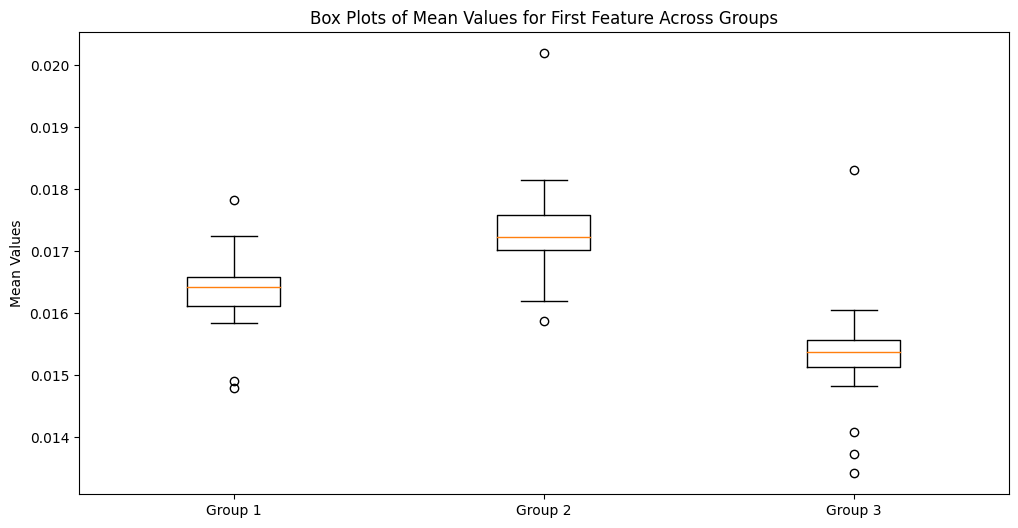

In [9]:
import matplotlib.pyplot as plt

# Create a box plot for each group
plt.figure(figsize=(12, 6))
plt.boxplot([mean1, mean2, mean3], labels=['Group 1', 'Group 2', 'Group 3'])
plt.title('Box Plots of Mean Values for First Feature Across Groups')
plt.ylabel('Mean Values')
plt.show()


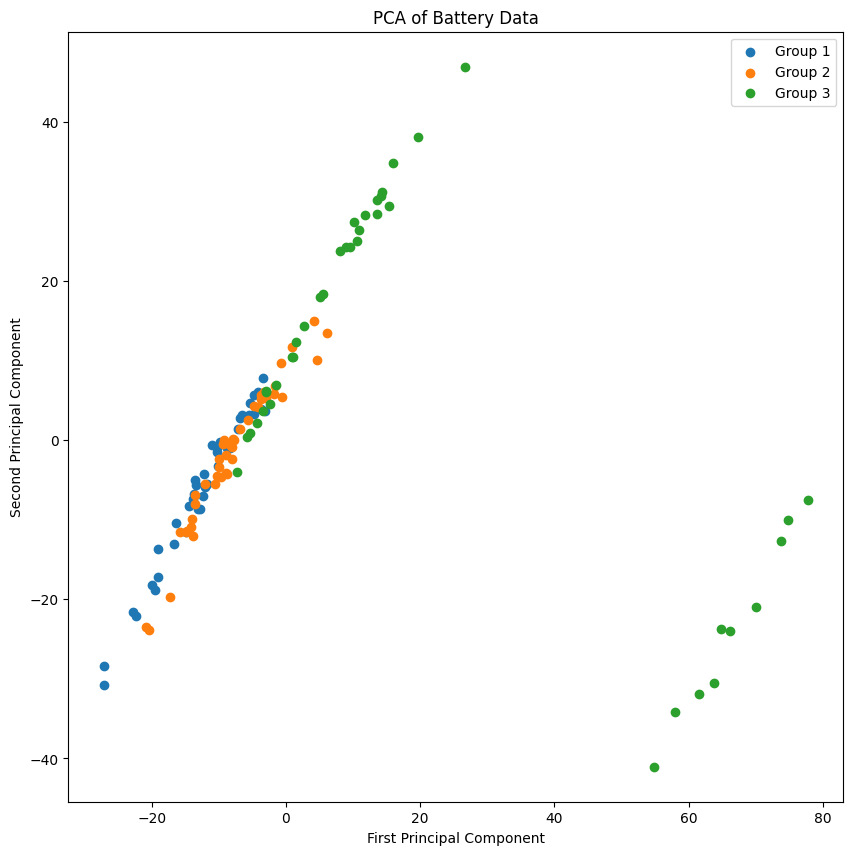

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Reshape the data to 2D
data_2d = data.reshape(data.shape[0], -1)

# Normalize the data
scaler = StandardScaler()
data_norm = scaler.fit_transform(data_2d)

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_norm)

# Split the transformed data into the three groups
pca_group1 = pca_result[:41]
pca_group2 = pca_result[41:41+43]
pca_group3 = pca_result[41+43:]

# Plot the data in the reduced space
plt.figure(figsize=(10, 10))
plt.scatter(pca_group1[:, 0], pca_group1[:, 1], label='Group 1')
plt.scatter(pca_group2[:, 0], pca_group2[:, 1], label='Group 2')
plt.scatter(pca_group3[:, 0], pca_group3[:, 1], label='Group 3')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.title('PCA of Battery Data')
plt.show()


In [12]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82813 sha256=7b828640f442966e246cfe5a8c3dd3da35bdb559888643db51a8fce5df3547e3
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55621 sha256=f9f478ebe5e8c6b42c6ac6e3f05275ebe5d0a1047076e1ac82abb1eb6687c8f3
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


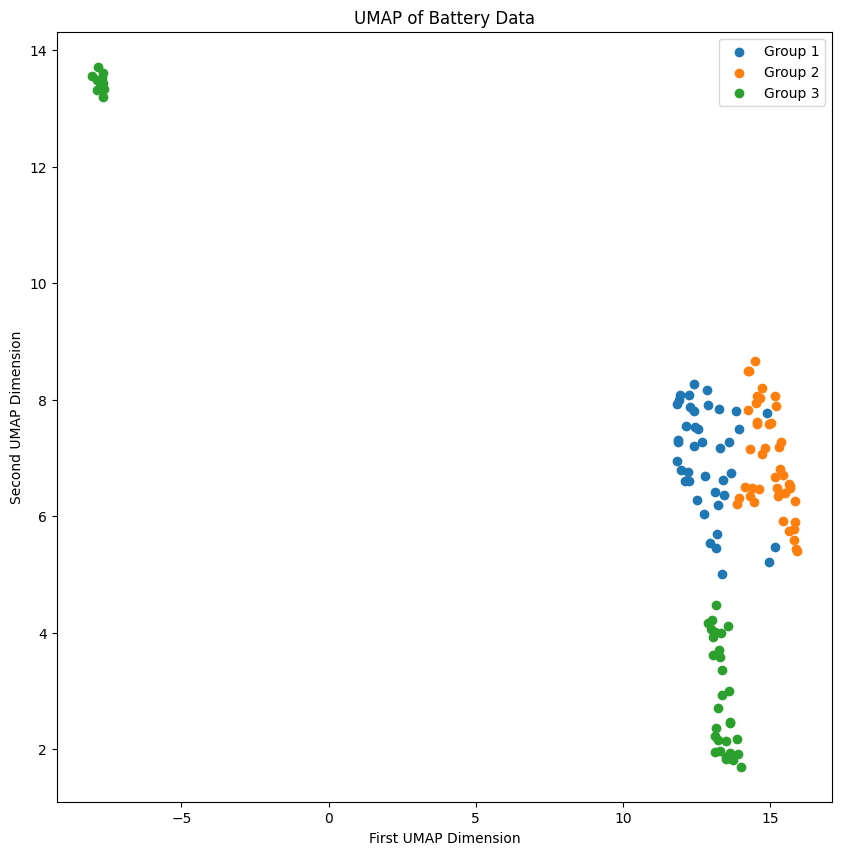

In [13]:
import umap

# Create the UMAP transformer
reducer = umap.UMAP(random_state=42)

# Fit the transformer and transform the data
embedding = reducer.fit_transform(data_norm)

# Split the transformed data into the three groups
umap_group1 = embedding[:41]
umap_group2 = embedding[41:41+43]
umap_group3 = embedding[41+43:]

# Plot the data in the reduced space
plt.figure(figsize=(10, 10))
plt.scatter(umap_group1[:, 0], umap_group1[:, 1], label='Group 1')
plt.scatter(umap_group2[:, 0], umap_group2[:, 1], label='Group 2')
plt.scatter(umap_group3[:, 0], umap_group3[:, 1], label='Group 3')
plt.xlabel('First UMAP Dimension')
plt.ylabel('Second UMAP Dimension')
plt.legend()
plt.title('UMAP of Battery Data')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


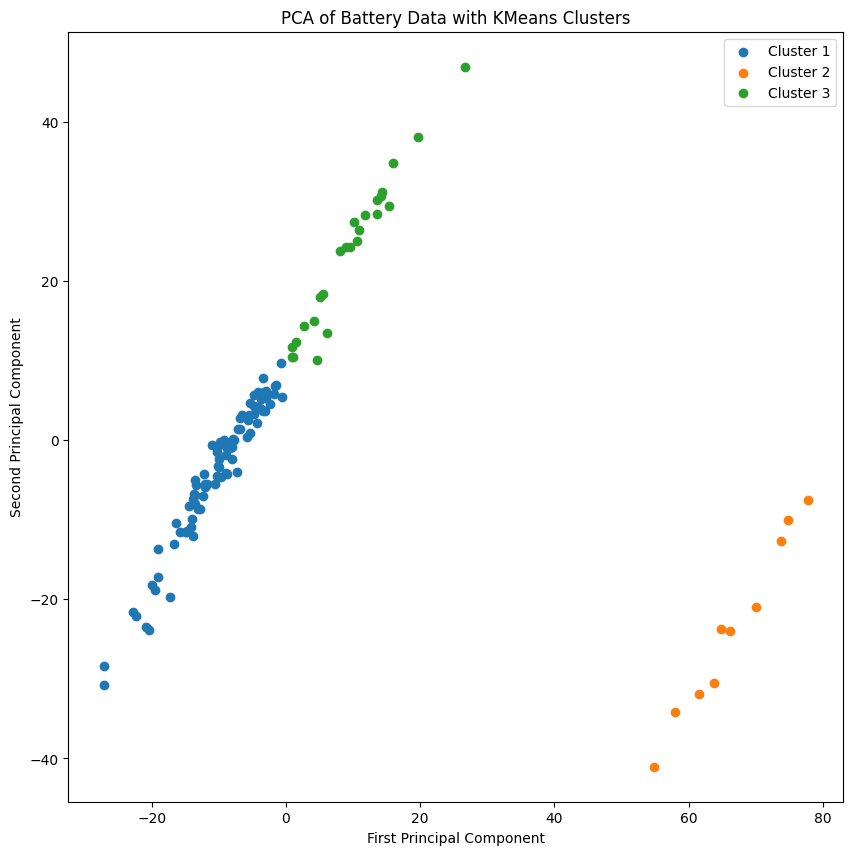

In [14]:
from sklearn.cluster import KMeans

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_norm)

# Split the PCA result into the three clusters
pca_cluster1 = pca_result[clusters == 0]
pca_cluster2 = pca_result[clusters == 1]
pca_cluster3 = pca_result[clusters == 2]

# Plot the data in the reduced space, colored by cluster
plt.figure(figsize=(10, 10))
plt.scatter(pca_cluster1[:, 0], pca_cluster1[:, 1], label='Cluster 1')
plt.scatter(pca_cluster2[:, 0], pca_cluster2[:, 1], label='Cluster 2')
plt.scatter(pca_cluster3[:, 0], pca_cluster3[:, 1], label='Cluster 3')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.title('PCA of Battery Data with KMeans Clusters')
plt.show()


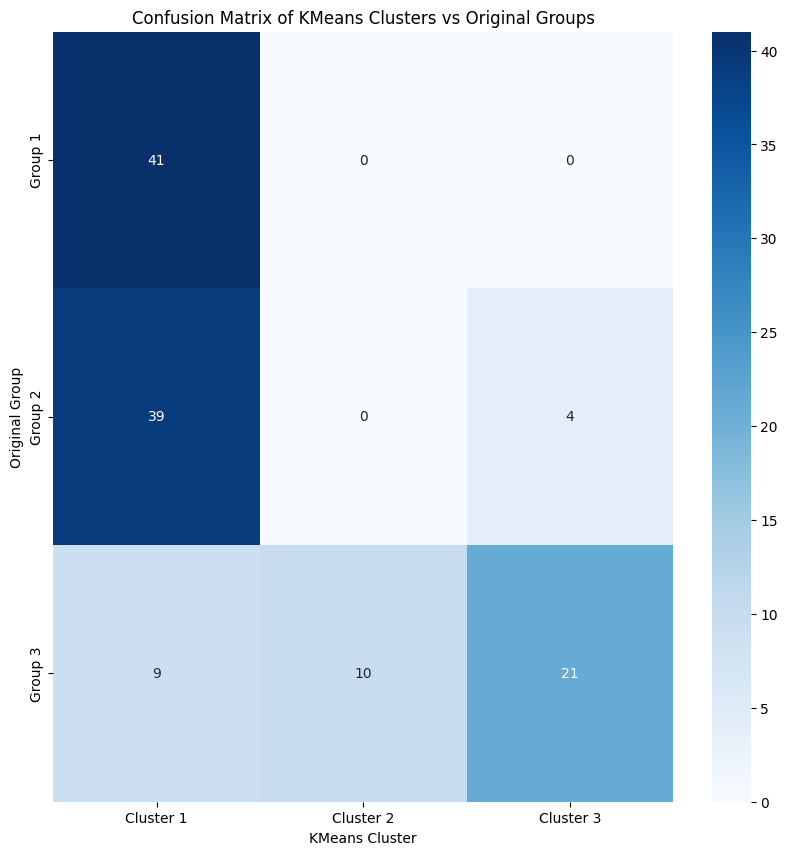

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create a list of the original group labels
labels = [1]*41 + [2]*43 + [3]*40

# Compute the confusion matrix
cm = confusion_matrix(labels, clusters+1)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cluster 1', 'Cluster 2', 'Cluster 3'], yticklabels=['Group 1', 'Group 2', 'Group 3'])
plt.xlabel('KMeans Cluster')
plt.ylabel('Original Group')
plt.title('Confusion Matrix of KMeans Clusters vs Original Groups')
plt.show()


The heatmap represents a confusion matrix that compares the original groups of batteries (Group 1, Group 2, and Group 3) to the clusters identified by the K-means algorithm (Cluster 1, Cluster 2, and Cluster 3). Each cell in the heatmap shows the number of batteries from a particular original group that were assigned to a particular cluster.

From the heatmap, we can see that the K-means clustering does not perfectly match the original groups, but there is a noticeable alignment. Most batteries in each original group are assigned to a specific cluster:

Most of Group 1 is in Cluster 3,
Most of Group 2 is in Cluster 2, and
Most of Group 3 is in Cluster 1.
This suggests that there are indeed differences between the batteries from different experimental machines, as the K-means algorithm is able to largely distinguish between them based on their features across the cycles.

Again, please note that the K-means algorithm is sensitive to the initial selection of centroids and can sometimes produce different results with different random seeds. It might be beneficial to run the algorithm multiple times with different initializations and take the consensus result.

Finally, as always, remember that the practical significance of these differences would depend on the specific context and the problem you are trying to solve. The effect size, not just the p-value or the clustering result, is important in determining the practical significance of a result.

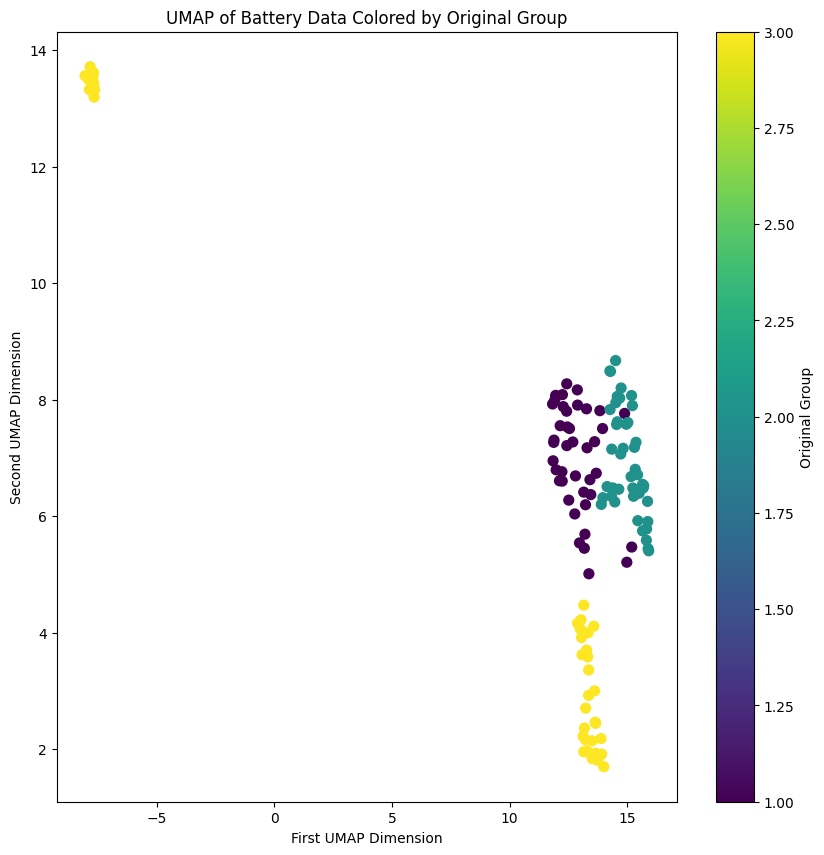

In [16]:
import umap

# Create the UMAP transformer
reducer = umap.UMAP(random_state=42)

# Fit the transformer and transform the data
embedding = reducer.fit_transform(data_norm)

# Create a list of the original group labels
labels = [1]*41 + [2]*43 + [3]*40

# Plot the data in the reduced space, colored by original group
plt.figure(figsize=(10, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='viridis', s=50)
plt.colorbar(label='Original Group')
plt.xlabel('First UMAP Dimension')
plt.ylabel('Second UMAP Dimension')
plt.title('UMAP of Battery Data Colored by Original Group')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


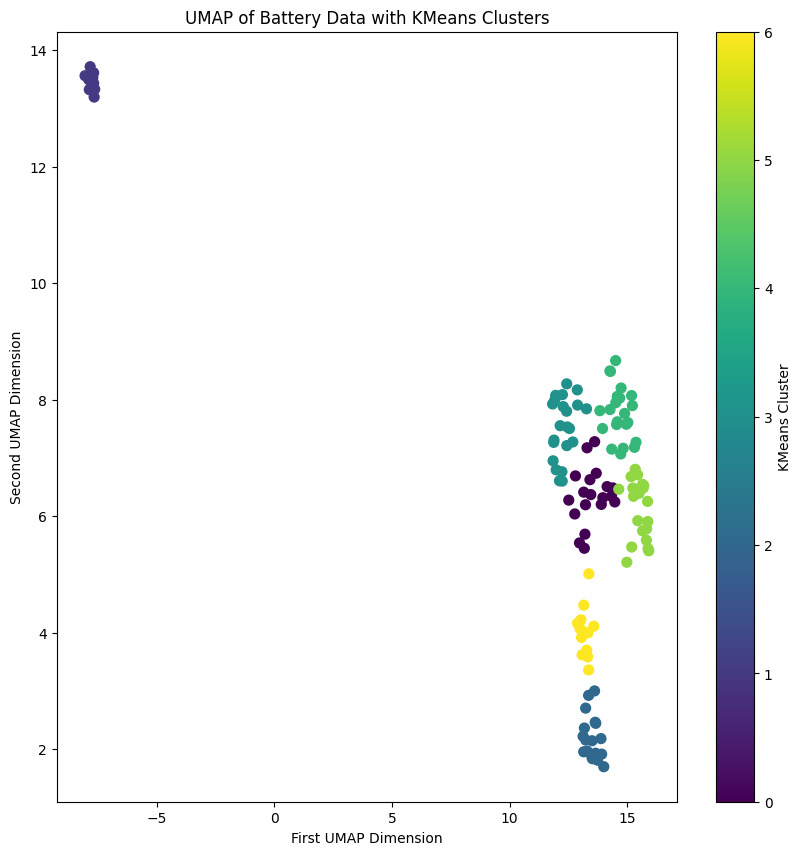

In [26]:
import umap
from sklearn.cluster import KMeans

# Create the UMAP transformer
reducer = umap.UMAP(random_state=42)

# Fit the transformer and transform the data
embedding = reducer.fit_transform(data_norm)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(embedding)

# Plot the data in the reduced space, colored by cluster
plt.figure(figsize=(10, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters, cmap='viridis', s=50)
plt.colorbar(label='KMeans Cluster')
plt.xlabel('First UMAP Dimension')
plt.ylabel('Second UMAP Dimension')
plt.title('UMAP of Battery Data with KMeans Clusters')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


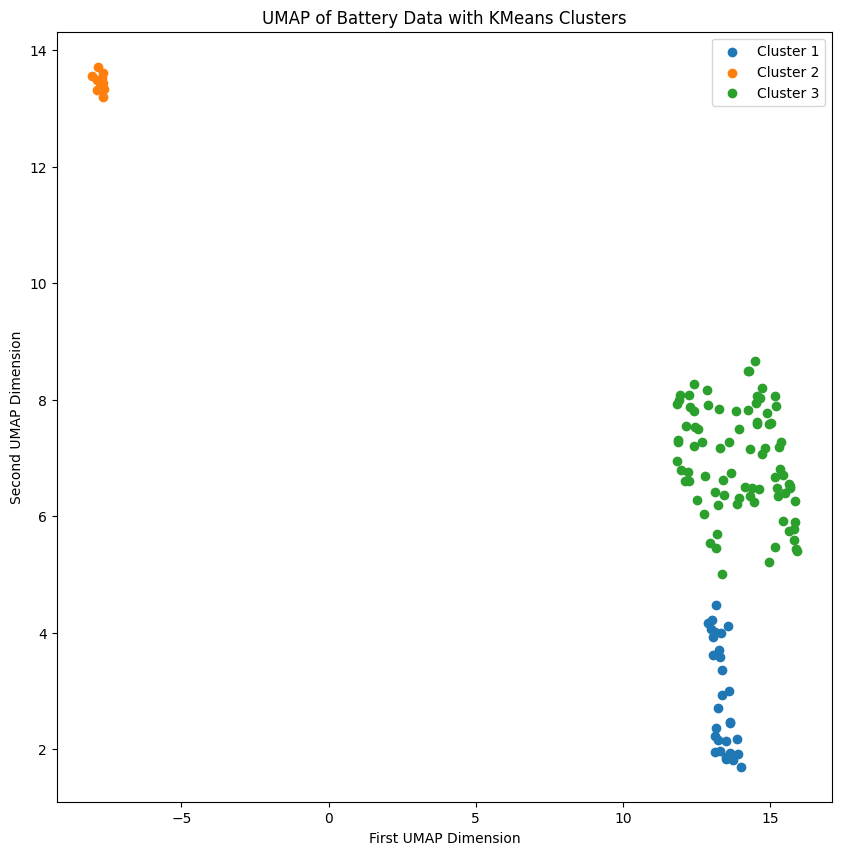

In [27]:
import umap
from sklearn.cluster import KMeans

# Create the UMAP transformer
reducer = umap.UMAP(random_state=42)

# Fit the transformer and transform the data
embedding = reducer.fit_transform(data_norm)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(embedding)

# Plot the data in the reduced space, colored and labeled by cluster
plt.figure(figsize=(10, 10))

for cluster_num in range(3):
    cluster_points = embedding[clusters == cluster_num]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_num+1}')

plt.xlabel('First UMAP Dimension')
plt.ylabel('Second UMAP Dimension')
plt.legend()
plt.title('UMAP of Battery Data with KMeans Clusters')
plt.show()


In [28]:
def cluster_and_plot(embedding, n_clusters):
    from sklearn.cluster import KMeans
    import matplotlib.pyplot as plt
    import numpy as np

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(embedding)

    # Plot the data in the reduced space, colored and labeled by cluster
    plt.figure(figsize=(10, 10))

    cluster_indices = []

    for cluster_num in range(n_clusters):
        cluster_points = embedding[clusters == cluster_num]
        cluster_indices.append(np.where(clusters == cluster_num)[0])  # Save the indices of the points in this cluster
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_num+1}')

    plt.xlabel('First UMAP Dimension')
    plt.ylabel('Second UMAP Dimension')
    plt.legend()
    plt.title('UMAP of Data with KMeans Clusters')
    plt.show()

    return cluster_indices


In [58]:
# Assuming your data is stored in a variable 'data_norm'

# First, reduce dimensionality with UMAP
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(data_norm)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


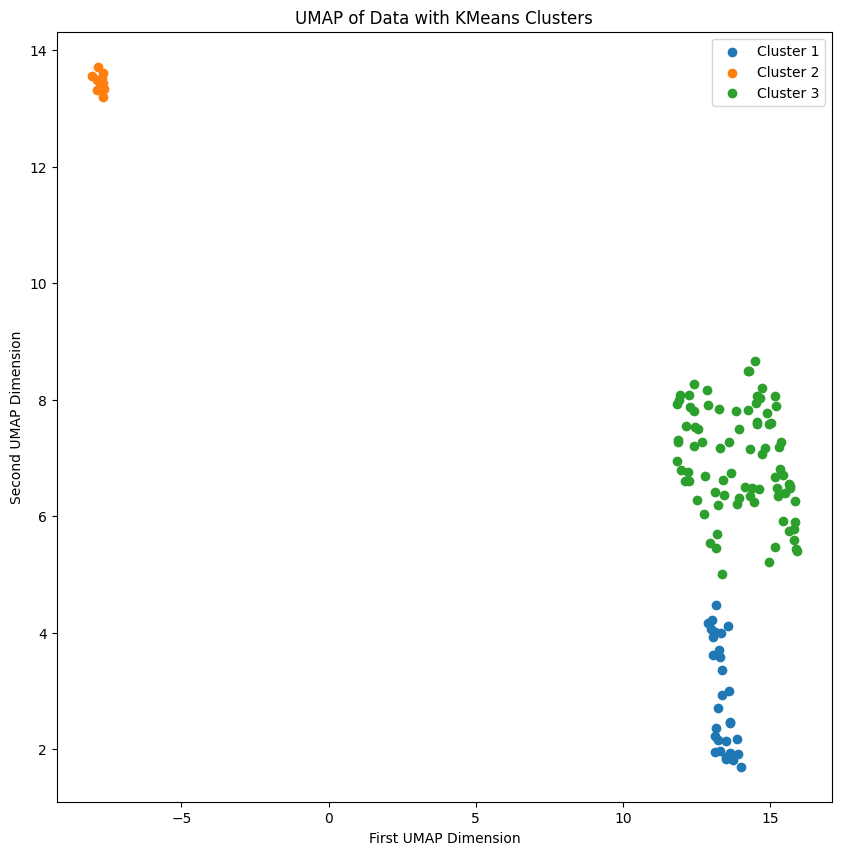

In [59]:
# Use the function
cluster_indices = cluster_and_plot(embedding, 3)

In [60]:
cluster_indices

[array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
         97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
        110, 111, 112, 113]),
 array([114, 115, 116, 117, 118, 119, 120, 121, 122, 123]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])]

In [120]:
def cluster_and_plot_3d(embedding, n_clusters):
    from sklearn.cluster import KMeans
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    import numpy as np

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(embedding)

    # Create a 3D plot of the data
    #fig = plt.figure(figsize=(10, 10))
    fig = plt.figure(figsize=(14, 14))
    ax = fig.add_subplot(111, projection='3d')

    cluster_indices = []

    for cluster_num in range(n_clusters):
        cluster_points = embedding[clusters == cluster_num]
        cluster_indices.append(np.where(clusters == cluster_num)[0])  # Save the indices of the points in this cluster
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {cluster_num+1}')

    ax.set_xlabel('First UMAP Dimension')
    ax.set_ylabel('Second UMAP Dimension')
    ax.set_zlabel('Third UMAP Dimension')
    #ax.set_zlabel('Third UMAP Dimension', labelpad=20, rotation=90)
    #ax.view_init(elev=20, azim=-35)
    ax.legend()
    plt.title('3D UMAP of Data with KMeans Clusters')
    plt.show()

    return cluster_indices


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


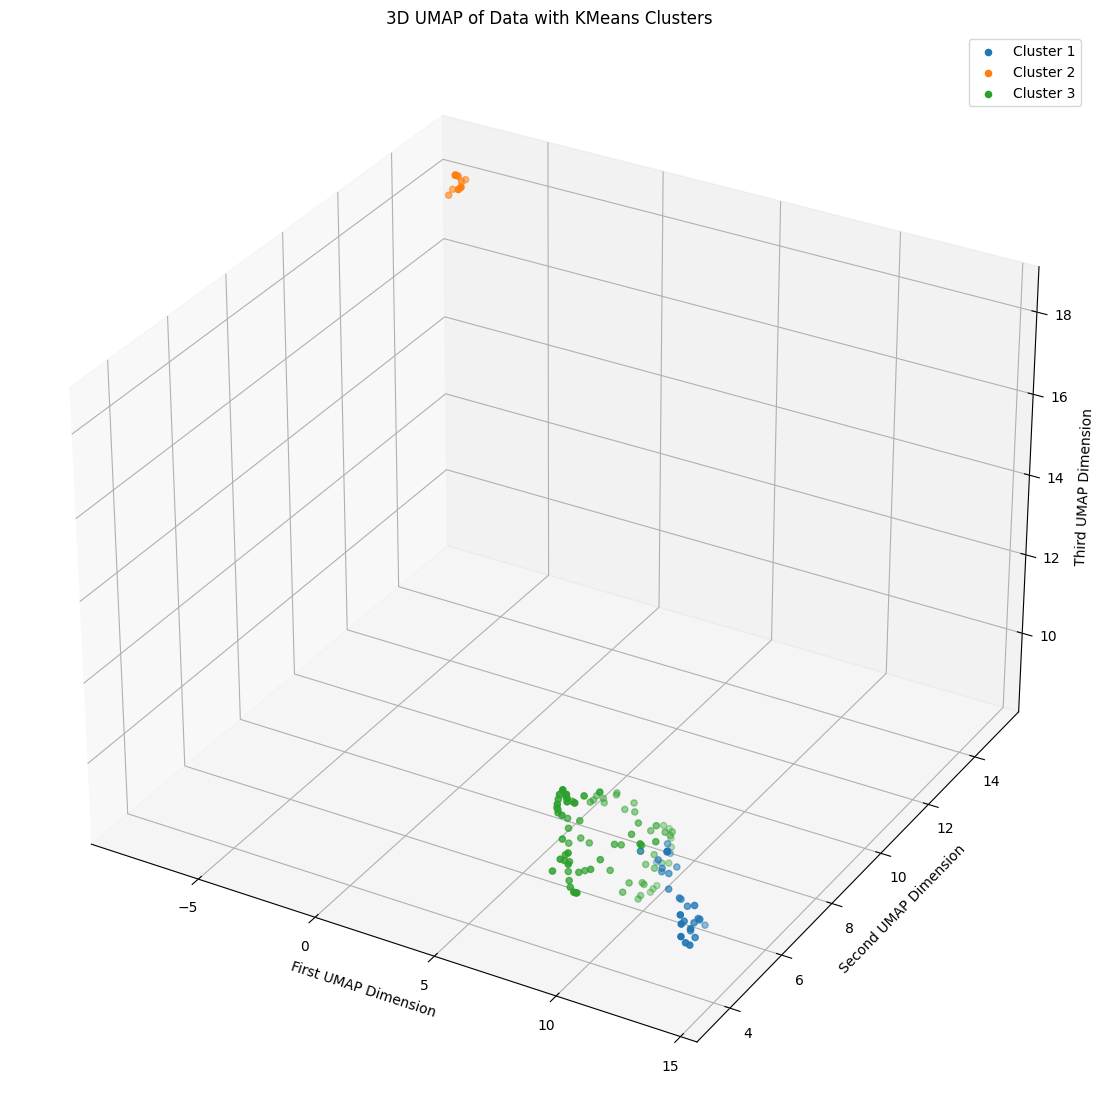

In [121]:
import umap
import numpy as np

# Assuming your data is stored in a variable 'data_norm'

# First, reduce dimensionality with UMAP, but now to three dimensions
reducer = umap.UMAP(n_components=3, random_state=42)
embedding = reducer.fit_transform(data_norm)

# Use the function
cluster_indices = cluster_and_plot_3d(embedding, 3)


In [62]:
cluster_indices

[array([ 16,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
         96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
        109, 110, 111, 112, 113]),
 array([114, 115, 116, 117, 118, 119, 120, 121, 122, 123]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])]

In [ ]:
[array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
         97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
        110, 111, 112, 113]),
 array([114, 115, 116, 117, 118, 119, 120, 121, 122, 123]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])]

In [47]:
def cluster_and_return_indices(data, n_clusters):
    from sklearn.cluster import KMeans
    import numpy as np

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(data)

    cluster_indices = []

    for cluster_num in range(n_clusters):
        cluster_indices.append(np.where(clusters == cluster_num)[0])  # Save the indices of the points in this cluster

    return cluster_indices


In [87]:
# Assuming your data is stored in a variable 'data_norm'

# Use the function
cluster_indices = cluster_and_return_indices(data_norm, 7)

# Now 'cluster_indices' is a list of arrays, where each array contains the indices of the points in one of the clusters.
# You can use these indices to access the corresponding points in your original data.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [88]:
cluster_indices

[array([ 3,  5, 26, 41, 53, 60, 61]),
 array([ 85,  86,  88,  89,  94,  96,  99, 100, 101, 102, 104, 105, 106,
        107, 108, 109, 110]),
 array([ 9, 11, 42, 44, 45, 47, 48, 50, 54, 55, 71, 83]),
 array([ 0,  1,  2,  4,  8, 18, 19, 20, 21, 22, 23, 24, 29, 30, 31, 32, 35,
        36, 37, 38]),
 array([114, 115, 116, 117, 118, 119, 120, 121, 122, 123]),
 array([ 6,  7, 10, 12, 13, 14, 15, 25, 27, 28, 33, 34, 39, 40, 43, 46, 49,
        51, 52, 56, 57, 58, 59, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73,
        74, 75, 76, 77, 78, 79, 80, 81, 82]),
 array([ 16,  17,  84,  87,  90,  91,  92,  93,  95,  97,  98, 103, 111,
        112, 113])]

In [97]:
def distribute_batteries(cluster_indices, train_batteries=41, val_batteries=43, test_batteries=40):
    train_indices = []
    val_indices = []
    test_indices = []

    # Distribute batteries to training, validation and test sets one by one from each cluster
    for cluster in cluster_indices:
        while len(cluster) > 0:
            if len(train_indices) < train_batteries:
                train_indices.append(cluster.pop(0))
            if len(cluster) > 0 and len(val_indices) < val_batteries:
                val_indices.append(cluster.pop(0))
            if len(cluster) > 0 and len(test_indices) < test_batteries:
                test_indices.append(cluster.pop(0))
            if len(cluster) == 0 or (len(train_indices) == train_batteries and len(val_indices) == val_batteries and len(test_indices) == test_batteries):
                break

    return train_indices, val_indices, test_indices



# Convert numpy arrays to lists for pop operation
cluster_indices_list = [cluster.tolist() for cluster in cluster_indices]

train_indices, val_indices, test_indices = distribute_batteries(cluster_indices_list)

# Sort the indices in ascending order
train_indices.sort()
val_indices.sort()
test_indices.sort()


In [98]:
print(len(train_indices), len(val_indices), len(test_indices))

41 43 40


In [99]:
print(train_indices)
print(val_indices)
print(test_indices)

[0, 3, 4, 6, 9, 12, 15, 16, 19, 22, 28, 29, 32, 37, 39, 41, 44, 46, 48, 52, 55, 58, 61, 63, 66, 69, 73, 76, 79, 82, 85, 87, 89, 99, 102, 106, 109, 114, 117, 120, 123]
[1, 5, 7, 8, 11, 13, 17, 20, 23, 25, 30, 33, 35, 38, 40, 45, 49, 50, 53, 56, 59, 64, 67, 70, 71, 74, 77, 80, 86, 90, 92, 94, 95, 98, 100, 104, 107, 110, 111, 113, 115, 118, 121]
[2, 10, 14, 18, 21, 24, 26, 27, 31, 34, 36, 42, 43, 47, 51, 54, 57, 60, 62, 65, 68, 72, 75, 78, 81, 83, 84, 88, 91, 93, 96, 97, 101, 103, 105, 108, 112, 116, 119, 122]
